In [261]:
from helpers import *
from Line import *
import pprint
pp = pprint.PrettyPrinter(indent=4)

TESTIMG = 'test_images/solidWhiteRight.jpg'
img = readImg(TESTIMG)
params = getParams()



%matplotlib inline  
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


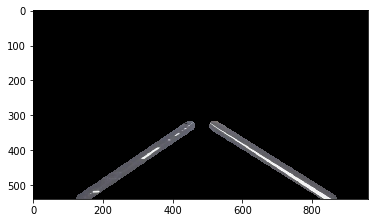

In [262]:
# %load lanedetector.py
from helpers import *

blkrSize = params["blurKernalSize"]
cht = params["cannyHT"]
clt = params["cannyLT"]
stage = params["outputStage"]


hsv = getHSV(img)

bMask = hsv[:,:,2] > params.get("bThresh", 200)

if params["useBrightness"]:
    # gray = hsv[:,:,2]
    gray = bMask.astype(np.uint8)*255
else:
    gray = grayscale(img)

blur = gaussian_blur(gray, kernel_size=blkrSize)

ht = cht
lt = clt
canny_edges = canny(blur, low_threshold=lt, high_threshold=ht)

#hsv = getHSV(img)
bMask = cv2.bitwise_and(img, img, mask=bMask.astype(np.uint8))
bMask = cv2.cvtColor(bMask, cv2.COLOR_BGR2RGB)


rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = params.get("hThresh", 10)
min_line_length = params.get("hMinLineLen", 20)
max_line_gap = params.get("hMaxLineGap", 1)



hLines = get_hough_lines(canny_edges, rho, theta, threshold, min_line_length, max_line_gap)
houghImg = draw_hough_lines(canny_edges, hLines)


lnValsLeft = []
lnValsRight = []

for l in hLines:
    ln = LineFromCVLine(l)
    if(ln.isValidLaneCandidate(params)):
        #if ln.distFromPoint(450,540) < 400:
        #if 540 - max(ln.y1, ln.y2) < 200:
            #ln.draw(linedImg)
            #print(ln.distFromPoint(450,540), ln.slope)
            
        lnVal = (540 - max(ln.y1, ln.y2) , ln.length(), ln.slope, ln)
        if(ln.slope < 0):
            lnValsLeft.append(lnVal)
        else:
            lnValsRight.append(lnVal)

lnValsLeft.sort(key=lambda x: x[0] + 1000/x[1])
lnValsRight.sort(key=lambda x: x[0] + 1000/x[1])
#pp.pprint(lnValsLeft)
#pp.pprint(lnValsRight)

#linedImg = np.copy(img)
linedImg = np.zeros_like(gray)

lnValsLeft[0][3].draw(linedImg)
lnValsRight[0][3].draw(linedImg)
lnValsLeft[0][3].extrapolateTillBase(linedImg,lnValsRight[0][3])
lnValsRight[0][3].extrapolateTillBase(linedImg,lnValsLeft[0][3])

lineMask = cv2.bitwise_and(img, img, mask=linedImg)
lineMask = cv2.cvtColor(lineMask, cv2.COLOR_BGR2RGB)

outpDict = {
        "final": lineMask,
        "blur": blur,
        "gray": gray,
        "canny": canny_edges,
        "hsv": hsv,
        "brightness": hsv[:,:,2],
        "hue": hsv[:,:,1],
        "saturation": hsv[:,:,0],
        "bMask": bMask,
        "hough": houghImg,

}

outImg = outpDict[stage]

showimg(outImg)

In [263]:
def findContours(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)
    thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)[1]

    # find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    #cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    return cnts[1]
cnts = findContours(lineMask)

#cnts[0]

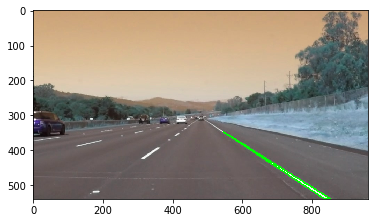

In [273]:
img = readImg(TESTIMG)
imgOut = cv2.drawContours(img, cnts, 3, (0,255,0), 3)
showimg(img)

In [274]:
l = LineFromCVLine(hLines[0])
cnts[3]

array([[[545, 348]],

       [[546, 349]],

       [[547, 349]],

       [[549, 351]],

       [[550, 351]],

       [[552, 353]],

       [[553, 353]],

       [[555, 355]],

       [[556, 355]],

       [[558, 357]],

       [[559, 357]],

       [[561, 359]],

       [[562, 359]],

       [[564, 361]],

       [[565, 361]],

       [[566, 362]],

       [[567, 362]],

       [[569, 364]],

       [[570, 364]],

       [[572, 366]],

       [[573, 366]],

       [[575, 368]],

       [[576, 368]],

       [[578, 370]],

       [[579, 370]],

       [[581, 372]],

       [[582, 372]],

       [[584, 374]],

       [[585, 374]],

       [[587, 376]],

       [[588, 376]],

       [[590, 378]],

       [[591, 378]],

       [[592, 379]],

       [[593, 379]],

       [[596, 382]],

       [[597, 382]],

       [[598, 383]],

       [[599, 383]],

       [[601, 385]],

       [[602, 385]],

       [[604, 387]],

       [[605, 387]],

       [[607, 389]],

       [[608, 389]],

       [[6

In [98]:
l = lnValsRight[0][3]
l.highPoint, l.lowPoint, l.slope

((526, 335.0), (853, 540), 0.6257668711656442)

In [99]:
theta = np.arctan(l.slope)
np.sin(theta) / np.cos(theta)

0.6257668711656442

In [191]:
distBwHighLow = l.distBetween(l.lowPoint[0], l.highPoint[0], l.lowPoint[1], l.highPoint[1])
distBwHighLow = np.sqrt(distBwHighLow)
distBwHighLow *= 0.2
distBwHighLow

77.18911840408595

In [192]:
midX = int(l.lowPoint[0] - distBwHighLow*np.cos(theta))
midY = int(l.lowPoint[1] - distBwHighLow*np.sin(theta))
midX, midY

(787, 499)

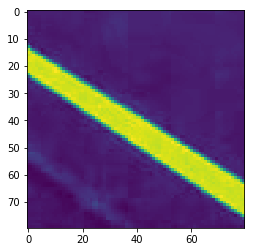

In [195]:
delta = 40
br = hsv[midY-delta:midY+delta,midX-delta:midX+delta,2]
showimg(br)

In [207]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(distFact=(-1.0,2.0,0.1), delta=(5,200,2))
def getLaneImg(distFact ,delta):
    distBwHighLow = l.distBetween(l.lowPoint[0], l.highPoint[0], l.lowPoint[1], l.highPoint[1])
    distBwHighLow = np.sqrt(distBwHighLow)
    distBwHighLow *= distFact
    midX = int(l.lowPoint[0] - distBwHighLow*np.cos(theta))
    midY = int(l.lowPoint[1] - distBwHighLow*np.sin(theta))
    br = hsv[midY-delta:midY+delta,midX-delta:midX+delta,2]
    plt.imshow(br)
    plt.show()
    print(delta)
    

In [169]:
br = hsv[:,:,2]
delta = 10
preVal = int(br[midY, midX-delta])
for i in range(midX-delta+1, midX+delta):
    print(i-midX, br[midY,i] , (preVal -  int(br[midY,i])) )
    preVal = br[midY,i]

(-9, 108, 0)
(-8, 105, 3)
(-7, 105, 0)
(-6, 106, -1)
(-5, 103, 3)
(-4, 112, -9)
(-3, 139, -27)
(-2, 179, -40)
(-1, 205, -26)
(0, 210, -5)
(1, 197, 13)
(2, 172, 25)
(3, 136, 36)
(4, 113, 23)
(5, 106, 7)
(6, 111, -5)
(7, 110, 1)
(8, 108, 2)
(9, 111, -3)
